In [ ]:
! pip install --upgrade pip
!pip install pystan==2.19.1.1 convertdate prophet

     |████████████████████████████████| 2.1 MB 36.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [ ]:
import pandas as pd
import os
import tqdm as tq
import string
import statistics as stats
import re
pd.set_option('display.max_columns', None) # allows to display all columns of a large dataframe
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import plotly.graph_objs as go

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
msoa_lst = ['E02000001', 
'W02000335',
 'W02000336',
 'W02000337',
 'W02000338',
 'W02000339',
 'W02000340',
 'W02000341',
 'W02000342',
 'W02000343',
 'W02000344',
 'W02000345',
 'W02000346',
 'W02000347',
 'W02000348',
 'W02000349',
 'W02000350',
 'W02000351',
 'W02000352',
 'W02000353',
 'W02000354',
 'W02000355',
 'W02000356',
 'W02000357',
 'W02000358',
 'W02000359',
 'W02000360',
 'W02000361',
 'W02000362',
 'W02000363',
 'W02000364',
 'W02000365',
 'W02000366']

In [ ]:
len(msoa_lst)

33

In [ ]:
df = pd.read_csv('/work/Prophet testing/crimes_and_features.csv')
df = df.loc[df['MSOA code'].isin(msoa_lst)]
df = df[df['MSOA code'] == 'E02000001']

In [ ]:
df2 = df[['Month', 'Sum crimes']]

df2 = df2.rename(columns={"Month":"ds"})
df2 = df2.rename(columns={"Sum crimes":'y'})
df2.astype({'ds': 'datetime64'}).dtypes
df2


,ds,y
0,2015-01,574
12602,2015-02,567
19803,2015-03,612
26409,2015-04,605
33609,2015-05,583
...,...,...
559467,2021-06,637
563317,2021-07,763
575050,2021-08,749
581244,2021-09,851


In [ ]:
string = pd.read_csv('/work/Stringency Index/stringency.csv')
string['ds'] = pd.to_datetime(string['Month'])

#Defining types of lockdowns
no_lock = string[string['stringency_index'] == 0]['ds'].to_list()
# med_lock = string[(string['stringency_index'] > 0) & (string['stringency_index'] < 50)]['ds'].to_list()
hard_lock = string[(string['stringency_index'] >= 50)]['ds'].to_list()

#Defining prophet 'holidays'
no_lockdown = pd.DataFrame({
    'holiday': 'no_lockdown',
    'ds': no_lock,
    'lower_window': 0,
    'upper_window': 0,
})

# med_lockdown = pd.DataFrame({
#     'holiday': 'med_lockdown',
#     'ds': med_lock,
#     'lower_window': 0,
#     'upper_window': 0,
# })

hard_lockdown = pd.DataFrame({
    'holiday': 'hard_lockdown',
    'ds': hard_lock,
    'lower_window': 0,
    'upper_window': 0,
})

holidays = pd.concat((no_lockdown, hard_lockdown))

In [ ]:
m = Prophet(holidays=holidays)
#m.add_country_holidays(country_name='GB')
m.fit(df2)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df2['ds'], y=df2['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Lockdown strictness',))
fig.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


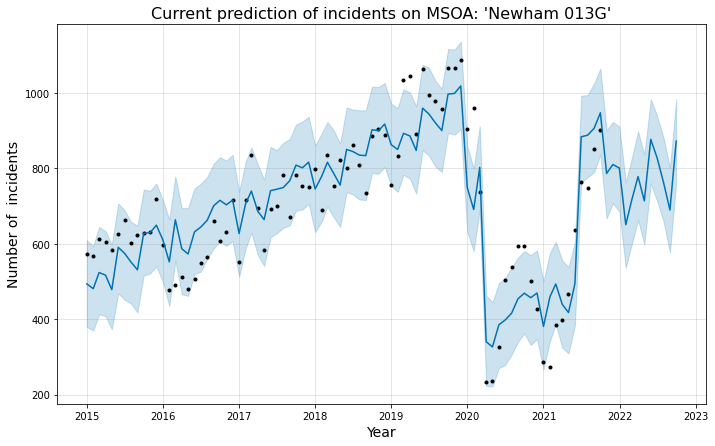

In [ ]:
m = Prophet(yearly_seasonality =True, holidays=holidays)
m.fit(df2)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

fig1 = m.plot(forecast)
ax = fig1.gca()
ax.set_title("Current prediction of incidents on MSOA: 'Newham 013G'", size=16)
ax.set_xlabel("Year", size=14)
ax.set_ylabel("Number of  incidents", size=14);

In [ ]:
# Initial training period.
initial= 30*70
initial= str(initial)+' days'
#Period length that we perform the cross validation for.
period = 30
period=str(period)+' days'
#Horizon of prediction essentially for each fold.
horizon = 61
horizon=str(horizon)+' days'
fb_cv=cross_validation(m,initial=initial,period=period, 
horizon=horizon)
# Performance Metrics of fb_cv

INFO:prophet:Making 11 forecasts with cutoffs between 2020-10-05 00:00:00 and 2021-08-01 00:00:00
100%|██████████| 11/11 [00:27<00:00,  2.54s/it]


In [ ]:
evaluation = performance_metrics(fb_cv, monthly =True, rolling_window=0.1)
evaluation

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1,32565.569375,180.459329,150.202153,0.329256,0.219361,0.270104,0.545455
1,2,41406.945284,203.486966,171.216727,0.356976,0.274768,0.288481,0.363636


In [ ]:
fb_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-11-01,444.882979,363.140930,536.028964,500,2020-10-05
1,2020-12-01,500.352259,413.436540,585.445181,426,2020-10-05
2,2020-12-01,502.884310,407.772317,590.185250,426,2020-11-04
3,2021-01-01,455.298109,370.259626,537.043902,287,2020-11-04
4,2021-01-01,455.481066,366.529906,543.472346,287,2020-12-04
5,2021-02-01,591.830424,501.704337,674.991328,274,2020-12-04
6,2021-02-01,580.067130,498.892363,665.536504,274,2021-01-03
7,2021-03-01,493.580089,410.345378,584.502508,385,2021-01-03
8,2021-03-01,469.453877,372.742281,571.157177,385,2021-02-02
9,2021-04-01,450.502082,357.983579,550.694962,398,2021-02-02


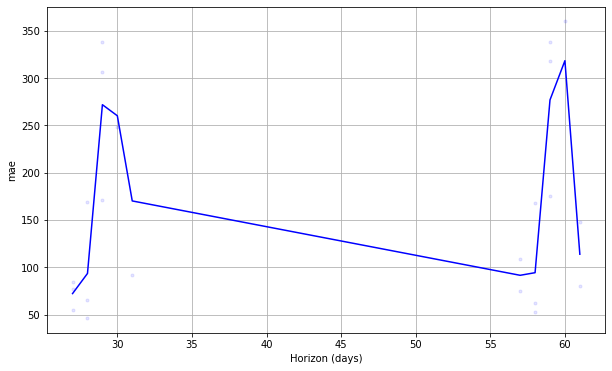

In [ ]:
fig = plot_cross_validation_metric(fb_cv, metric='mae')

In [ ]:
#Splitting train and test
train = df2[df2['ds'] <= '2020-10']
test = df2[df2['ds'] > '2020-10']
test

,ds,y
507325,2020-11,500
514358,2020-12,426
523643,2021-01,287
527267,2021-02,274
534772,2021-03,385
545059,2021-04,398
547276,2021-05,468
559467,2021-06,637
563317,2021-07,763
575050,2021-08,749


In [ ]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
77,2021-05-31
78,2021-06-30
79,2021-07-31
80,2021-08-31
81,2021-09-30


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
77,2021-05-31,839.672259,624.484567,1042.693434
78,2021-06-30,771.788933,571.358005,974.980559
79,2021-07-31,760.376563,564.239329,967.667924
80,2021-08-31,765.997784,556.553101,969.885915
81,2021-09-30,1017.860542,813.131892,1231.377434


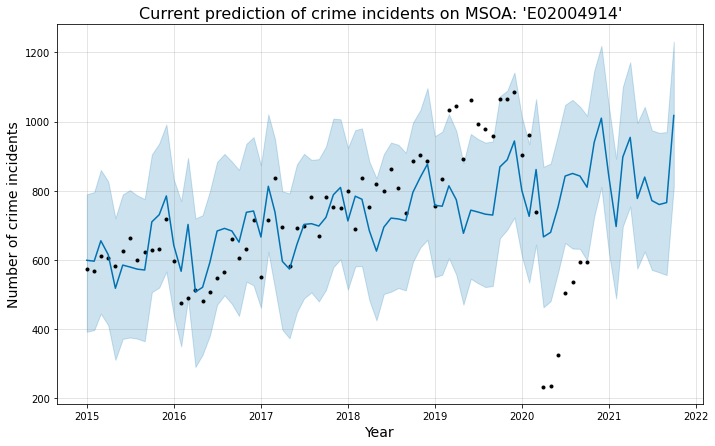

In [ ]:
fig1 = m.plot(forecast, uncertainty=True)
ax = fig1.gca()
ax.set_title("Current prediction of crime incidents on MSOA: 'E02004914'", size=16)
ax.set_xlabel("Year", size=14)
ax.set_ylabel("Number of crime incidents", size=14);

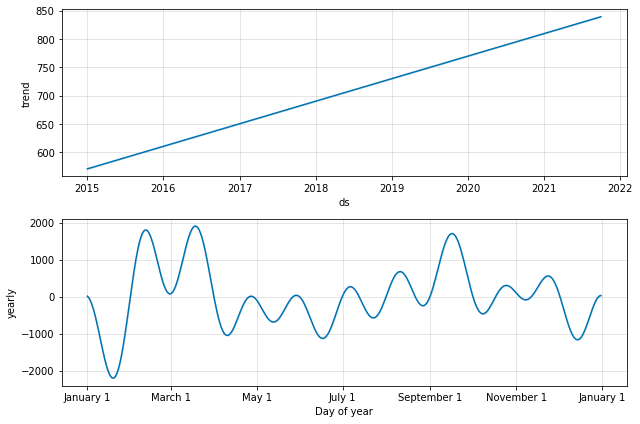

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

In [ ]:
forecast[forecast]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,571.137397,392.540401,790.002647,571.137397,571.137397,27.997918,27.997918,27.997918,27.997918,27.997918,27.997918,0.0,0.0,0.0,599.135315
1,2015-02-01,574.510845,397.305658,796.078465,574.510845,574.510845,22.055933,22.055933,22.055933,22.055933,22.055933,22.055933,0.0,0.0,0.0,596.566778
2,2015-03-01,577.557831,444.937111,860.220851,577.557831,577.557831,78.057337,78.057337,78.057337,78.057337,78.057337,78.057337,0.0,0.0,0.0,655.615168
3,2015-04-01,580.931279,411.065889,827.042243,580.931279,580.931279,34.314878,34.314878,34.314878,34.314878,34.314878,34.314878,0.0,0.0,0.0,615.246157
4,2015-05-01,584.195906,311.323725,720.904226,584.195906,584.195906,-66.027907,-66.027907,-66.027907,-66.027907,-66.027907,-66.027907,0.0,0.0,0.0,518.167999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2021-05-31,825.828523,624.484567,1042.693434,825.826144,825.830970,13.843736,13.843736,13.843736,13.843736,13.843736,13.843736,0.0,0.0,0.0,839.672259
78,2021-06-30,829.088270,571.358005,974.980559,829.085380,829.091205,-57.299337,-57.299337,-57.299337,-57.299337,-57.299337,-57.299337,0.0,0.0,0.0,771.788933
79,2021-07-31,832.456676,564.239329,967.667924,832.453102,832.460208,-72.080113,-72.080113,-72.080113,-72.080113,-72.080113,-72.080113,0.0,0.0,0.0,760.376563
80,2021-08-31,835.825081,556.553101,969.885915,835.821008,835.829293,-69.827297,-69.827297,-69.827297,-69.827297,-69.827297,-69.827297,0.0,0.0,0.0,765.997784


In [ ]:
df_train = df[df['Month'] <= '2020-10']
df_test = df[df['Month'] > '2020-10']
df_test

,Unnamed: 0,Month,MSOA code,Crime type_Anti-social behaviour,Crime type_Bicycle theft,Crime type_Burglary,Crime type_Criminal damage and arson,Crime type_Drugs,Crime type_Other crime,Crime type_Other theft,Crime type_Possession of weapons,Crime type_Public order,Crime type_Robbery,Crime type_Shoplifting,Crime type_Theft from the person,Crime type_Vehicle crime,Crime type_Violence and sexual offences,Sum crimes,Median Age,life_exp_m,life_exp_f,life_exp_m65,life_exp_f_65,energy_eff_score,Total annual income
507325,507325,2020-11,E02000001,83.0,47.0,6.0,12.0,57.0,7.0,45.0,4.0,34.0,17.0,66.0,61.0,10.0,51.0,500,38.15,90.37,90.74,90.74,27.61,72,65400
514358,514358,2020-12,E02000001,71.0,14.0,11.0,24.0,49.0,9.0,48.0,5.0,26.0,10.0,50.0,35.0,13.0,61.0,426,38.15,90.37,90.74,90.74,27.61,72,65400
523643,523643,2021-01,E02000001,65.0,6.0,6.0,10.0,30.0,4.0,27.0,1.0,21.0,3.0,38.0,17.0,7.0,52.0,287,38.15,90.37,90.74,90.74,27.61,72,65400
527267,527267,2021-02,E02000001,60.0,6.0,6.0,10.0,29.0,7.0,12.0,4.0,20.0,9.0,31.0,33.0,8.0,39.0,274,38.15,90.37,90.74,90.74,27.61,72,65400
534772,534772,2021-03,E02000001,62.0,11.0,7.0,19.0,54.0,8.0,20.0,3.0,47.0,3.0,39.0,28.0,13.0,71.0,385,38.15,90.37,90.74,90.74,27.61,72,65400
545059,545059,2021-04,E02000001,71.0,25.0,16.0,16.0,43.0,2.0,33.0,2.0,31.0,15.0,43.0,35.0,7.0,59.0,398,38.15,90.37,90.74,90.74,27.61,72,65400
547276,547276,2021-05,E02000001,79.0,26.0,14.0,10.0,44.0,4.0,55.0,3.0,34.0,8.0,47.0,69.0,12.0,63.0,468,38.15,90.37,90.74,90.74,27.61,72,65400
559467,559467,2021-06,E02000001,101.0,21.0,14.0,29.0,52.0,9.0,67.0,6.0,73.0,11.0,69.0,54.0,20.0,111.0,637,38.15,90.37,90.74,90.74,27.61,72,65400
563317,563317,2021-07,E02000001,111.0,28.0,21.0,30.0,50.0,10.0,94.0,4.0,70.0,16.0,80.0,101.0,15.0,133.0,763,38.15,90.37,90.74,90.74,27.61,72,65400
575050,575050,2021-08,E02000001,77.0,33.0,24.0,36.0,50.0,7.0,124.0,4.0,58.0,13.0,77.0,103.0,23.0,120.0,749,38.15,90.37,90.74,90.74,27.61,72,65400


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

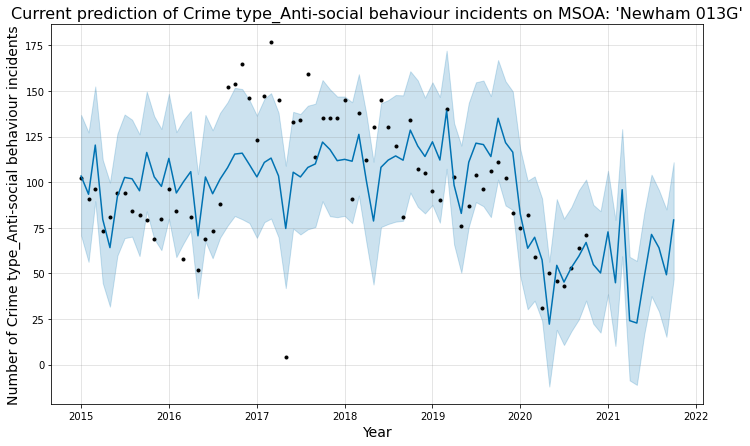

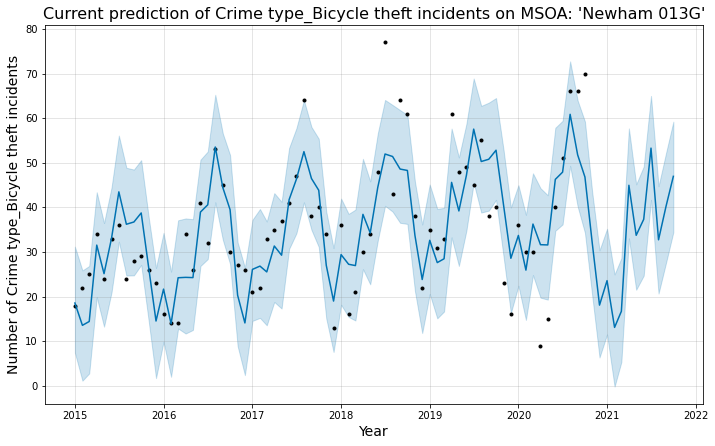

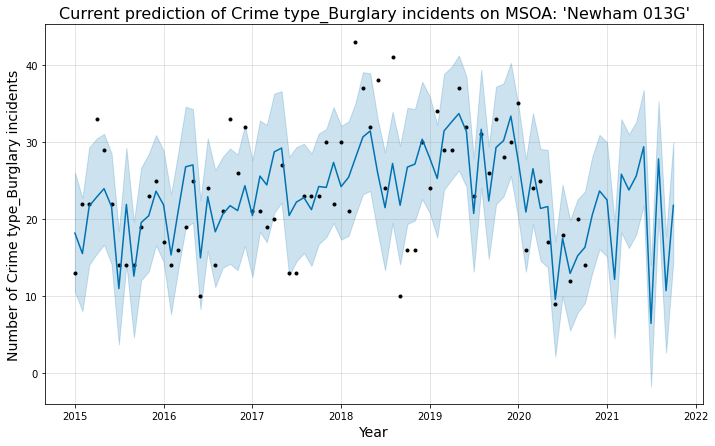

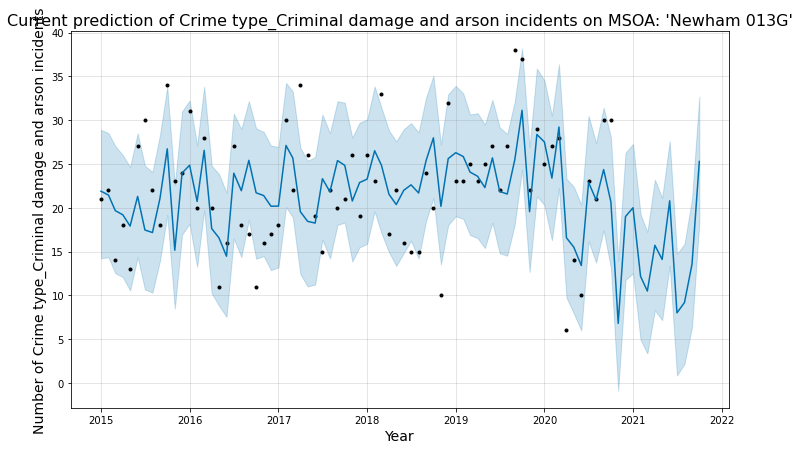

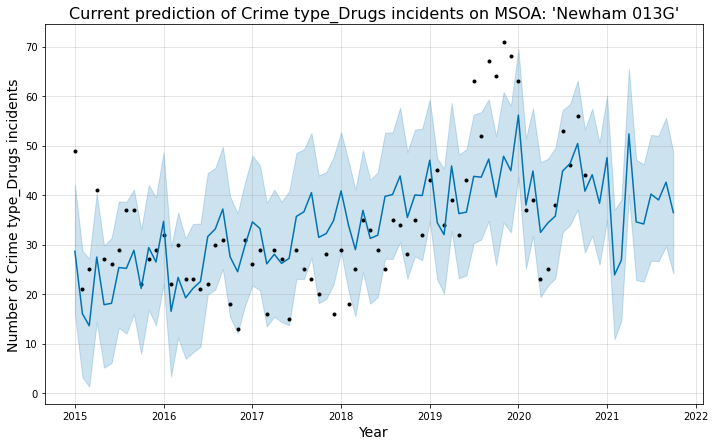

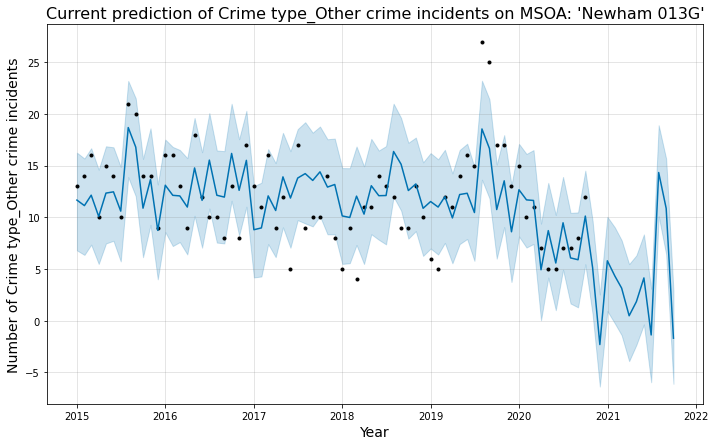

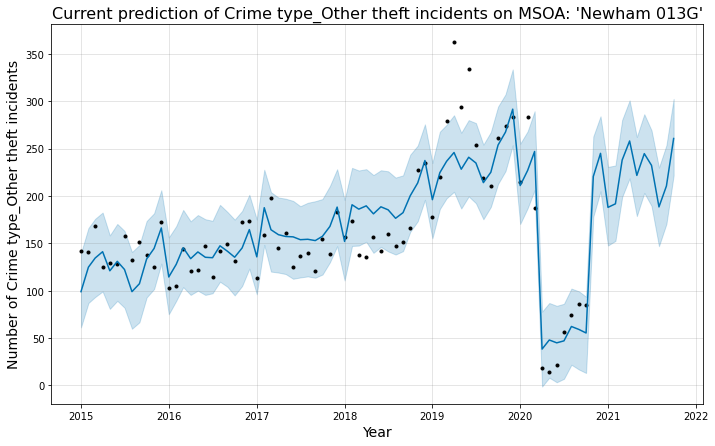

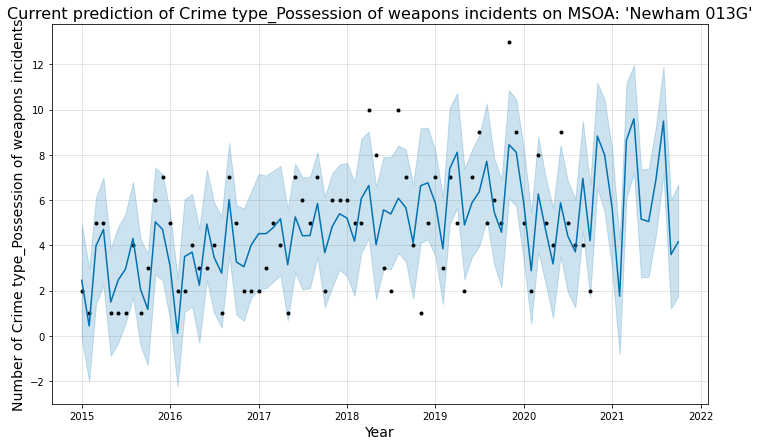

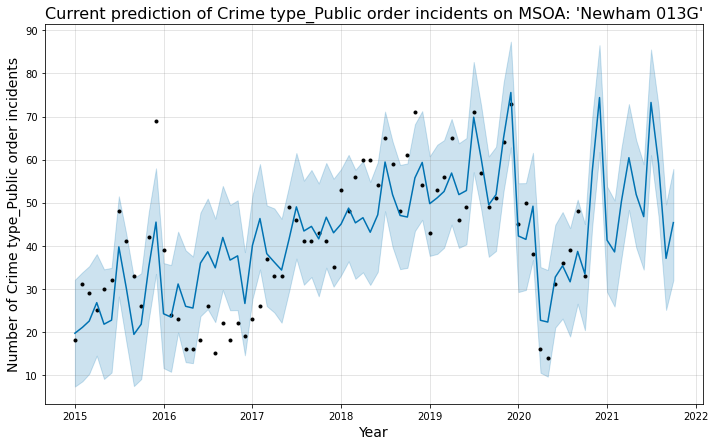

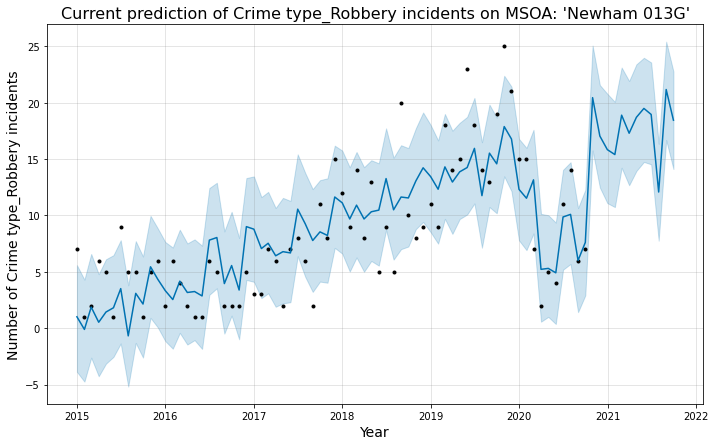

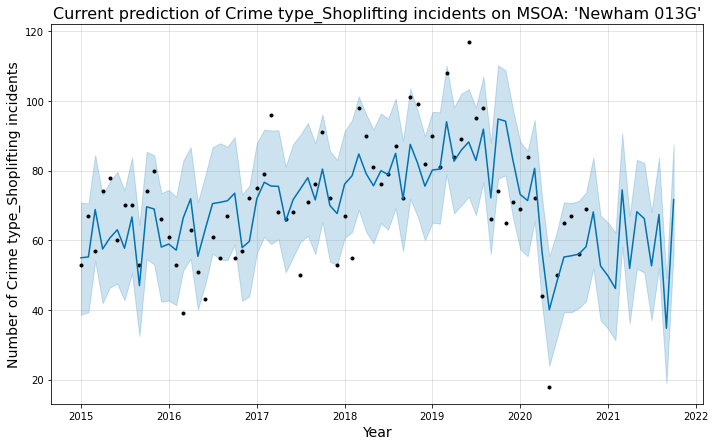

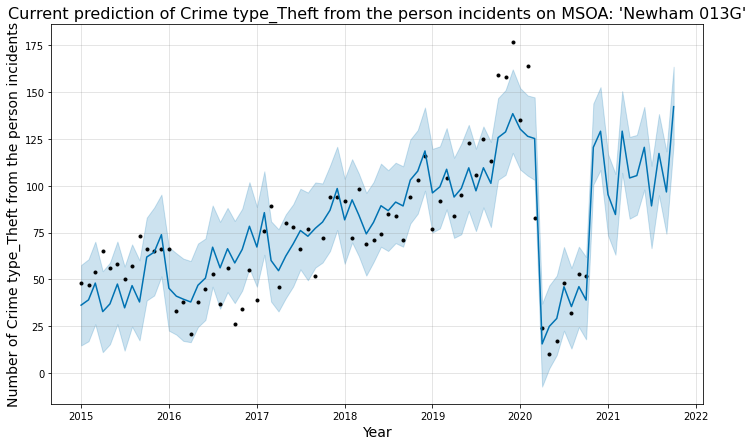

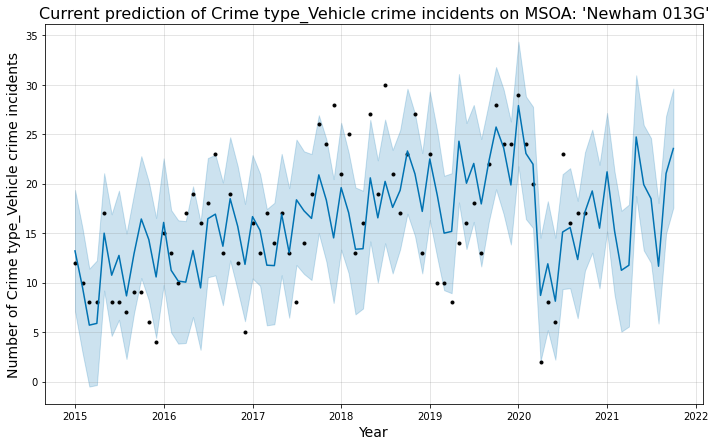

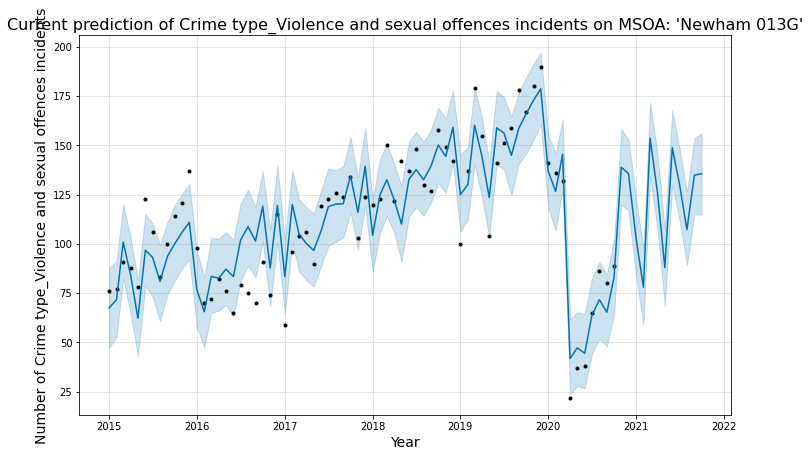

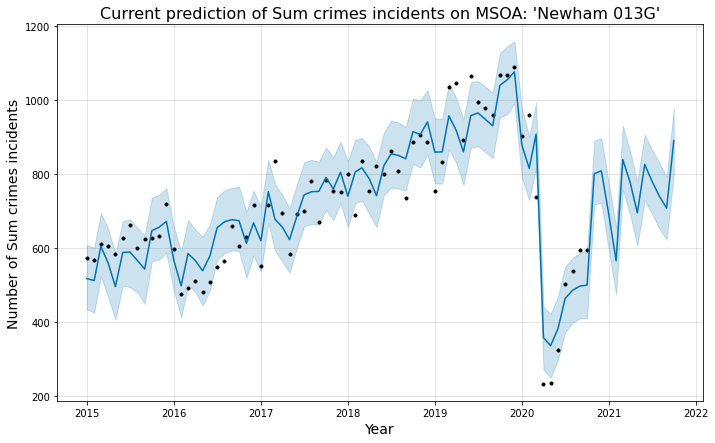

In [ ]:
#This loops over every crime type in the dataset and makes seperate predicitons about the amount of that type
#one year ahead of time, per month and prints a forecasting figure as result
i = 3
forecasts = []
crime_types = []
while i<=17: #replace 3 by once dataset implemented df.count(axis='columns')
     

    df_train2 = df_train.iloc[:, [1, i]]
    crime_type = df_train2.columns.values[1]
    df_train2.columns.values[0] = "ds"
    df_train2.columns.values[1] = "y"
    df_train2.astype({'ds': 'datetime64[ns]'}).dtypes
    crime_types.append(crime_type)
    m = Prophet(holidays=holidays, yearly_seasonality =True)
    m.fit(df_train2)

    future = m.make_future_dataframe(periods=12, freq='M')

    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    forecasts.append(forecast)

    fig1 = m.plot(forecast)
    ax = fig1.gca()
    ax.set_title("Current prediction of " + crime_type + " incidents on MSOA: 'Newham 013G'", size=16)
    ax.set_xlabel("Year", size=14)
    ax.set_ylabel("Number of " + crime_type + " incidents", size=14);
    i +=1


In [ ]:
j=0
while j < len(forecasts):
    i=0
    error = []
    forecast = forecasts[j]
    while i<len(test):
        x = forecast.iloc[i]["trend"]
        y = df_test.iloc[i][j+3]
        error.append(abs(y-x))
        i += 1
    MAE = sum(error)/len(error)
    print("MAE for", crime_types[j] ,"is", MAE)
    j +=1

MAE for Crime type_Anti-social behaviour is 55.91043587998744
MAE for Crime type_Bicycle theft is 16.740167089177945
MAE for Crime type_Burglary is 8.35379986455098
MAE for Crime type_Criminal damage and arson is 14.378381335991472
MAE for Crime type_Drugs is 36.39344335845349
MAE for Crime type_Other crime is 2.9316873785201594
MAE for Crime type_Other theft is 52.31412979126396
MAE for Crime type_Possession of weapons is 3.307416830231246
MAE for Crime type_Public order is 40.76954752448385
MAE for Crime type_Robbery is 11.69372358514876
MAE for Crime type_Shoplifting is 39.09980869620888
MAE for Crime type_Theft from the person is 52.6567508019528
MAE for Crime type_Vehicle crime is 10.122331397491157
MAE for Crime type_Violence and sexual offences is 70.24797927438102
MAE for Sum crimes is 412.8567612742236


In [ ]:
j=0
while j< len(forecasts):
    i=0
    error = []
    while i<len(test):
        x = forecast.iloc[i]["trend"]
        y = df_test.iloc[i][j+3]
        error.append((y-x)**2)
        i += 1
    MSE = sum(error)/len(error)
    print("MSE for", crime_types[j] ,"is", MSE)
    j +=1

MSE for Crime type_Anti-social behaviour is 3738.9218027956035
MSE for Crime type_Bicycle theft is 13261.398856287626
MSE for Crime type_Burglary is 16030.676574317484
MSE for Crime type_Criminal damage and arson is 14081.980653592216
MSE for Crime type_Drugs is 8965.06454328889
MSE for Crime type_Other crime is 17974.067795453448
MSE for Crime type_Other theft is 6425.261863587089
MSE for Crime type_Possession of weapons is 18801.8280051659
MSE for Crime type_Public order is 9076.036884055628
MSE for Crime type_Robbery is 16850.884638119507
MSE for Crime type_Shoplifting is 7026.531324121886
MSE for Crime type_Theft from the person is 6571.523986910607
MSE for Crime type_Vehicle crime is 16004.794619777946
MSE for Crime type_Violence and sexual offences is 3546.337238011849
MSE for Sum crimes is 209585.17321398392


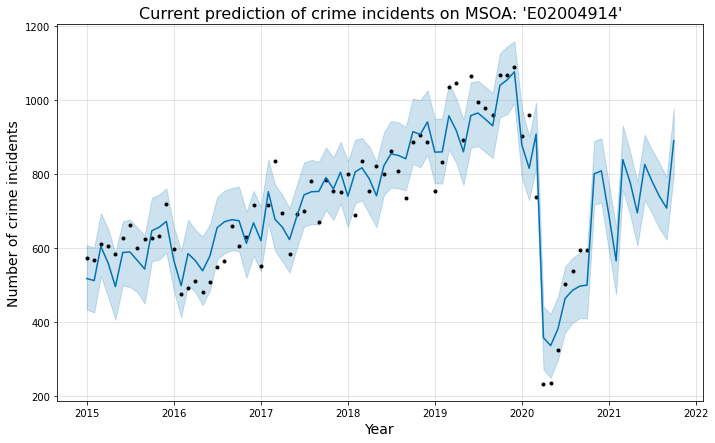

In [ ]:
fig1_m = m.plot(forecast)
ax = fig1_m.gca()
ax.set_title("Current prediction of crime incidents on MSOA: 'E02004914'", size=16)
ax.set_xlabel("Year", size=14)
ax.set_ylabel("Number of crime incidents", size=14);

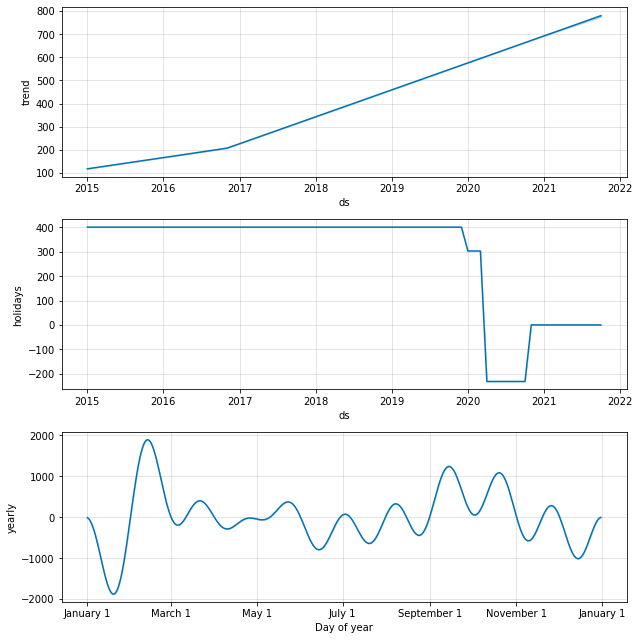

In [ ]:
fig2_m = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [ ]:


print (len(train),len(test))

70 12


In [ ]:
# Initial training period.
#initial= 30*len(train)
#initial= str(initial)+' days'
#Period length that we perform the cross validation for.
#period= 30*len(test)
#period=str(period)+' days'
#Horizon of prediction essentially for each fold.
#horizon = 30*12
#horizon=str(horizon)+' days'
#fb_cv=cross_validation(m,initial=initial,period=period,
#horizon=horizon)
# Performance Metrics of fb_cv
#performance_metrics(fb_cv)

In [ ]:
#MAE attempt
i=0
error = []
while i<len(test):
    x = forecast.iloc[i]["trend"]
    y = test.iloc[i]["y"]
    error.append(abs(y-x))
    i += 1
MAE = sum(error)/len(error)
print(MAE)


412.8567612742236


In [ ]:
#MSE attempt
i=0
error = []
while i<len(test):
    x = forecast.iloc[i]["trend"]
    y = test.iloc[i]["y"]
    error.append((y-x)**2)
    i += 1
MSE = sum(error)/len(error)
print(MSE)

209585.17321398392


## Hyperparameter tuning

In [ ]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in tq.tqdm(all_params):
    m = Prophet(**params).fit(df2)  # Fit model with given params
    df_cv = cross_validation(m, initial = 70*30 horizon=61, period = 30, parallel="processes") # add cutoffs?
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

  0%|          | 0/128 [00:00<?, ?it/s]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 67 forecasts with cutoffs between 2016-01-27 00:00:00 and 2021-08-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff204881b50>
INFO:prophet:n_changepoints greater than number of observations. Using 9.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
INFO:prophet:n_changepoi

KeyboardInterrupt: 

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)
# {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}

NameError: name 'all_params' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=40789b9a-1c62-45b9-9d9c-b1a39ebe3dfd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>